The full "Water Observations from Space" product consists not only of water extents and water frequency statistics, but also a confidence layer. This last incorporates ancillary products.

In [1]:
# prepare environment
import datacube
import geopandas
import rasterio, rasterio.features
import matplotlib.pyplot as plt
import xarray
import numpy as np
import scipy, scipy.ndimage
dc = datacube.Datacube()

In [2]:
# set up region of interest
canberra = dict(lat=(-34.9, -35.4), lon=(149.0,149.5))
timerange = ('1986-01-01','1987-01-01')
print(dc.index.datasets.count(product='wofs_albers'))
wofls = dc.load(product='wofs_albers', time=timerange, **canberra)
print(len(wofls.time))
geobox = wofls.geobox

2141
1


In [3]:
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None):
    """Blit like"""
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

Example of the water frequency. The codes are: 0 for clear dry, 128 for clear wet, other values for masked. However, wish to deprecate the sea bitflag (decimal 4). 

In [4]:
%matplotlib inline

/g/data1/u46/users/brl654/tools/python/anaconda/install/envs/pyramid/lib/python3.5/site-packages/xarray-0.8.2-py3.5.egg/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


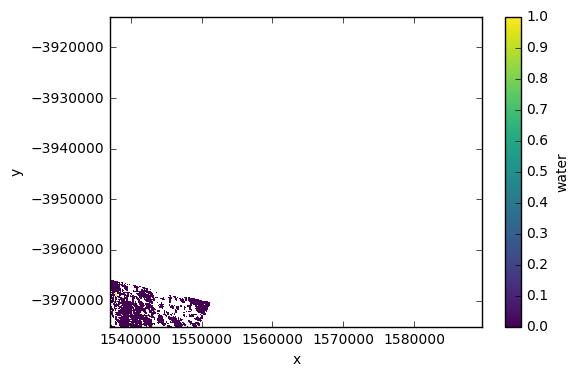

In [5]:
regardless_of_sea = ~np.uint8(4) # ignore bit-flag 1<<2
water = wofls.water & regardless_of_sea
wet = (water == 128).sum(dim='time')
dry = (water == 0).sum(dim='time')
freq = wet/(wet+dry)
freq.plot()

The weights are specified in the WOfS journal paper.

In [6]:
wofl_wet_freq = 0.1703
MrVBF = 0.1671
MODIS_OWL = 0.0336
slope = -0.2522
geofabric_foreshore = 4.2062
geofabric_pondage = -5.4692
geofabric_reservoir = 0.6574
geofabric_flat = 0.7700
geofabric_lake = 1.9992
geofabric_swamp = 1.3231
geofabric_watercourse = 1.9206
urban_areas = -4.9358

## Urban centre and locality (ASGS vol. 4 2011)
This is a single shapefile, but must be pre-filtered on attributes.

In [7]:
def urban(geobox):
    ucl_path = "/g/data/v10/wofs/ancillary/ucl/UCL_2011_AUST.shp"
    u = geopandas.read_file(ucl_path) # load shapes table
    u = u[u['SOS_NAME11']=='Major Urban'] # filter out <100k
    u = u.to_crs(geobox.crs._crs.ExportToProj4()) # reproject
    array = rasterio.features.rasterize(shapes=u.geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, 'urban')
ucl = urban(geobox)

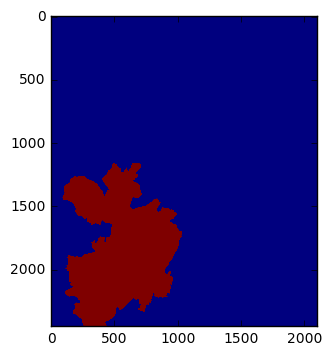

In [8]:
plt.imshow(ucl.data)

## Hydrological Geofabric
The Australian Hydrological Geospatial Fabric version 2.1 is divided into six products, of which only Surface Cartography is considered here. This product is a geodatabase with 17 layers, most of which do not store polygons; neglecting sea, only the (AHGF-) Waterbody and HydroArea layers are potentially relevant. These layers contain feature-types no. 25-27 and 54-59 respectively: 
 - The waterbody layer contains: reservoir, lake, flats (swamp);
 - The hydroarea layer contains: watercourse, canal, flats (including marine swamp), pondage, rapids, foreshore-flats. 

From among these, canal and rapid are omitted by the regression model. In reference to the WOfS paper, type 27 will be identified with "swamp" and 56 with "flats". A few of the classes (i.e. reservoirs, pondage, and hydro-area flats) contain subtypes and these are not distinguished here.


In [9]:
"""
SrcFCName, SrcFType, AHGFFType

AHGFWaterbody
    Flats ['Swamp'] [27]
    Lakes ['Lake'] [26]
    Reservoirs ['Town Rural Storage', 'Flood Irrigation Storage'] [25]

AHGFHydroArea
    CanalAreas ['Canal Area'] [55]
    Flats ['Land Subject To Inundation', 'Saline Coastal Flat', 'Marine Swamp'] [56]
    ForeshoreFlats ['Foreshore Flat'] [59]
    PondageAreas ['Settling Pond', 'Aquaculture Area', 'Salt Evaporator'] [57]
    RapidAreas ['Rapid Area'] [58]
    WatercourseAreas ['Watercourse Area'] [54]
"""
  
geofabric_weights = {'AHGFHydroAreaFlats': geofabric_flat, # includes marine swamp
                     'AHGFHydroAreaForeshoreFlats': geofabric_foreshore,
                     'AHGFHydroAreaPondageAreas': geofabric_pondage,
                     'AHGFHydroAreaWatercourseAreas': geofabric_watercourse,
                     'AHGFWaterbodyFlats': geofabric_swamp, # type 27
                     'AHGFWaterbodyLakes': geofabric_lake,
                     'AHGFWaterbodyReservoirs': geofabric_reservoir}

def geofabric_parts(geobox):
    geofabric_path = "/g/data/v10/wofs/ancillary/geofabric/SH_Cartography_GDB/SH_Cartography.gdb"
    # fiona.listlayers(geofabric_path)
    for layer in ['AHGFHydroArea', 'AHGFWaterbody']: # consider these two layers
        table = geopandas.read_file(geofabric_path, layer=layer)[['AHGFFType','SrcFCName','SrcFType','geometry']]
        for fc, df in table.groupby('SrcFCName'):
            if fc not in ['CanalAreas', 'RapidAreas']: # exclude these two feature classes
                name = layer+fc
                yield geofabric_weights[name], geopandas_to_xarray(df, geobox, name=name)

def geofabric(geobox):
    return sum(weight*array for weight, array in geofabric_parts(geobox))
                
g = geofabric(geobox)

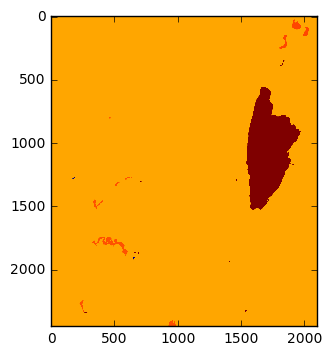

In [10]:
plt.imshow(g.data)

## Slope
Sobel on the DSM.

Note, technically this requires a couple pixels of margin padding.

In [11]:
def slope_degrees(geobox):
    pad = 5 # pixels of margin buffering
    
    dem = dc.load(product='dsm1sv10', # ? 'srtm_dem1sv1_0'
                  geopolygon=geobox[-pad:geobox.height+pad, -pad:geobox.width+pad].extent,
                  output_crs=geobox.crs, # force target gridspec
                  resolution=geobox.resolution).isel(time=0)
    
    # Sobel is prefered gradient method from DEM-grid literature.
    xgrad = scipy.ndimage.sobel(dem.elevation, axis=1) / abs(8*dem.affine.a) # i.e. dz/dx
    ygrad = scipy.ndimage.sobel(dem.elevation, axis=0) / abs(8*dem.affine.e)
    # Here, assuming orthogonal grid. Probably shouldn't.
      
    #slope = numpy.degrees(numpy.arctan(numpy.hypot(xgrad, ygrad)))
    slope = np.degrees(np.arccos(1.0/np.sqrt(xgrad**2 + ygrad**2 + 1.0)))
    # Tangential vectors have basis x+dz/dx z, y+dz/dy z.
    # Perpendicularity implies normal is colinear with z - dz/dx x - dz/dy y.
    # The slope cosine is given by the dot product of the normal with vertical
    # (i.e. by the vertical component of the normal, after magnitude normalisation).
    # Note, an alternative approach is to project the normal into the horizontal plane 
    # (delaying magnitude normalisation until afterward),
    # and consider the rise in this direction of steepest ascent (seems like fewer operations).
    
    return numpy_to_xarray(slope[pad:-pad,pad:-pad],geobox,'slope') # strip padding

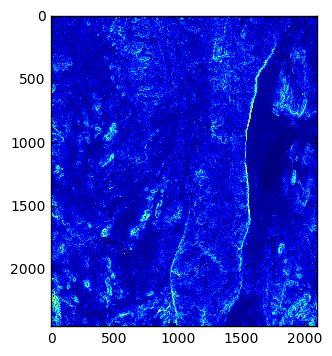

In [12]:
slant = slope_degrees(geobox)
plt.imshow(slant.data)

## MrVBF

In [13]:
mrvbf_path = "/g/data/v10/wofs/ancillary/mrvbf/mrvbf_int.tif"
vbf = rasterfile_to_xarray(mrvbf_path, geobox, nodata=10)

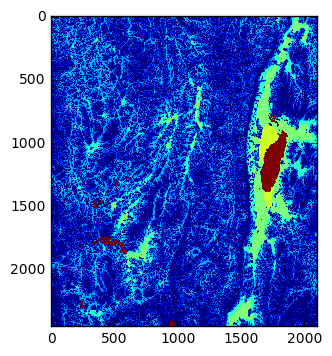

In [14]:
plt.imshow(vbf.data)

In [15]:
vbf = rasterfile_to_xarray(mrvbf_path, geobox) # let nodata remain at 255

## MODIS OWL

In [16]:
modis_path = "/g/data/v10/wofs/ancillary/modis/MOD09A1.aust.005.OWL.0.2.4.2001.2010.GE.20.tif"
owl = rasterfile_to_xarray(modis_path, geobox)

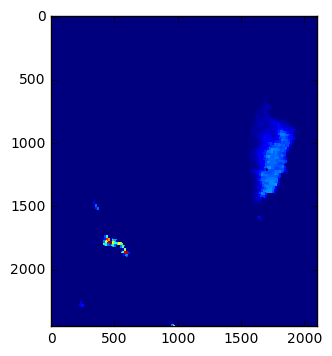

In [17]:
plt.imshow(owl.data)

## Synthesis
Finally bringing all the layers together.

First there is the ancillary terms (a weighted sum that excludes the observation frequency term), then there is the full confidence layer. Finally, there is the filtered summary.

In [18]:
ancillary = g + slope*slant + MODIS_OWL*owl + MrVBF*vbf + urban_areas*ucl

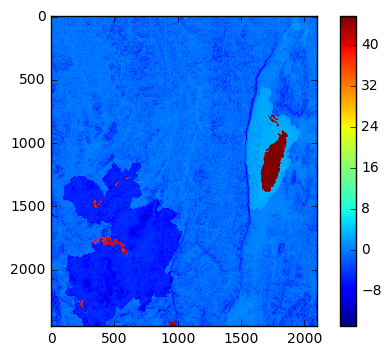

In [19]:
plt.imshow(ancillary.data)
plt.colorbar()

In [20]:
freq2 = freq.copy()
freq2.data = np.nan_to_num(freq.data) # NaN -> 0
confidence = scipy.special.expit(ancillary + wofl_wet_freq*freq2)

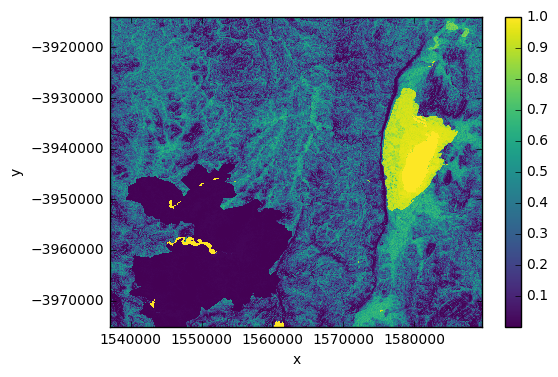

In [21]:
confidence.plot()

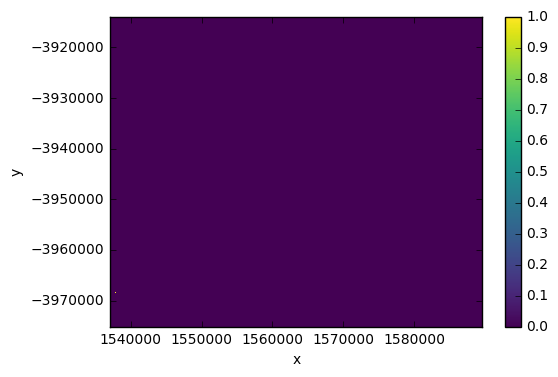

In [22]:
# filtered summary
threshold = 0.05
(freq2*(confidence>threshold)).plot()